### Active Data Resource Interface Objects (ADRIOs) Phase 1

The ADRIO system is being developed as a way to simplify the process of assembling GEOs as part of the simulation workflow. ADRIOs are derived from an abstract class and each exists to interface with a specific resource and extract specific data from that resource (doing any necessary filtering and transformation along the way). Future implementations will utilize ADRIO templates for different data sources, but only a generalized outline exists for now. The ADRIOs created in this phase are used to satisfy an example use case. That is:

I am a modeler working on a disease with human-to-human transmission and I believe certain social determinants of health are a significant factor in disease outcomes. I want to use EpiMoRPH to model a metapopulation at the county level in the US Southwest region. My existing disease data, that I hope to use for parameter fitting, comes from 2015. I need the following data for each county, filtering to Arizona, New Mexico, Nevada, Utah, and Colorado:

- Each county’s name and state.
- Geographic centroid.
- Population in 2015, total as well as aggregated into age brackets: under 20, 20-to-64, and 65 and older.
- Population density.
- Median household annual income.
- The [Dissimilarity Index](https://www.phenxtoolkit.org/protocols/view/211403) of racial segregation for selected minority groups (currently African Americans) calculated from the census tracts comprising each county.


All data for this use case comes from Census tables and/or shape files. As such, a US Census API key is required to download much of it. These ADRIOs are configured to search for a key in an environment variable named "CENSUS_API_KEY". Please make sure you have an [API key](https://api.census.gov/data/key_signup.html) and have assigned it to an environment variable with this name if running the code yourself.

The following 8 cells demonstrate the execution of each ADRIO. Each will fetch one of the required data fields and return it as a numpy array.

In [3]:
from epymorph.adrio.uscounties.name_and_state import NameAndState

adrio = NameAndState() # County and state name for all counties

data = adrio.fetch(nodes=['04','08','49','35','32'])   # Parameters are US state fips codes of the states relevant to the use case

print(data[:10])

5 items retrieved from cache
['Apache County, Arizona' 'Cochise County, Arizona'
 'Coconino County, Arizona' 'Gila County, Arizona'
 'Graham County, Arizona' 'Greenlee County, Arizona'
 'La Paz County, Arizona' 'Maricopa County, Arizona'
 'Mohave County, Arizona' 'Navajo County, Arizona']


In [5]:
from epymorph.adrio.uscounties.geoid import GEOID

adrio = GEOID() # GEOID for all counties

data = adrio.fetch(nodes=['04','08','49','35','32'])

print(data[:10])

5 items retrieved from cache
['04001' '04003' '04005' '04007' '04009' '04011' '04012' '04013' '04015'
 '04017']


In [6]:
from epymorph.adrio.uscounties.centroid import Centroid

adrio = Centroid() # Geographic centroid for all counties

data = adrio.fetch(nodes=['04','08','49','35','32'])

print(data[:10])

5 items retrieved from cache
[(-118.33577887439804, 39.58087638098897)
 (-115.0135616989219, 36.2151981007958)
 (-119.61637202421979, 38.91224140787554)
 (-115.35771562105954, 41.145844176906984)
 (-117.63236603239478, 37.78469655140272)
 (-116.26855959836149, 39.98389202381407)
 (-118.11196813868902, 41.40684244857626)
 (-117.03790840153665, 39.93380604825583)
 (-114.8775399789504, 37.64333859826016)
 (-119.1891968409386, 39.02039771529712)]


In [7]:
from epymorph.adrio.uscounties.population import Population

adrio = Population()  # Total population for each county

data = adrio.fetch(nodes=['04','08','49','35','32'])

print(data[:10])

5 items retrieved from cache
[  72124  129647  136701   53165   37407    9023   20335 4018143  203362
  107656]


In [8]:
from epymorph.adrio.uscounties.population_by_age import PopulationByAge

adrio = PopulationByAge()  # Aggregated population for each county

data = adrio.fetch(nodes=['04','08','49','35','32'])

print(data[:10])

5 items retrieved from cache
[[   5704   13817    4271]
 [ 474694 1244219  285819]
 [   8704   25536   11884]
 [  14226   31726    5336]
 [    305     562     318]
 [    519    1004     233]
 [   4839   10089    2116]
 [   1714    3355     842]
 [   1276    2832    1104]
 [  11613   28387   10836]]


In [9]:
from epymorph.adrio.uscounties.median_income import MedianIncome

adrio = MedianIncome()  # Median income for each county

data = adrio.fetch(nodes=['04','08','49','35','32'])

print(data[:10])

5 items retrieved from cache
[31757 45075 50234 39751 45964 51628 34466 54229 38488 35921]


In [1]:
from epymorph.adrio.uscounties.pop_density_km2 import PopDensityKm2

adrio = PopDensityKm2() # Population density for each county

data = adrio.fetch(nodes=['04','08','49','35','32'])

print(data[:10])

5 items retrieved from cache
5 items retrieved from cache
[  2.   8.   3.   4.   3.   2.   2. 169.   6.   4.]


In [11]:
from epymorph.adrio.uscounties.dissimilarity_index import DissimilarityIndex

adrio = DissimilarityIndex()    # Dissimilarity index for Afrian Americans for each county

data = adrio.fetch(nodes=['04','08','49','35','32'])

print(data[:10])

5 items retrieved from cache
5 items retrieved from cache
[0.56844015 0.33530496 0.51208923 0.49214145 0.5        0.5
 0.57185422 0.5        0.51741716 0.24060141]


### GEO Assembly

ADRIOs being able to individually fetch data is great, but we also need a more streamlined way to create a GEO object using data from a whole set of ADRIOs. That's where GEOSpecs come in. GEOSpecs are objects containing a list of geographic nodes and a list of ADRIOSpec objects, which are simply used to specify which ADRIOs to call on by their class name.

The below code creates a GEOSpec object through its initializer and serializes it to a .geo file using a predefined serialize method. With this file created, an entry can be added to the geo_library in epymorph.data.__init__, mapping the name of the Geo (in this case us_sw_counties_2015) to a string file path pointing to its .geo file.

In [1]:
from epymorph.adrio.adrio import GEOSpec, ADRIOSpec, serialize

spec = GEOSpec('us_sw_counties_2015', ['04','08','49','35','32'], 
                                       ADRIOSpec('NameAndState'),      # label ADRIO
                                      [ADRIOSpec('GEOID'),
                                       ADRIOSpec('Centroid'),
                                       ADRIOSpec('MedianIncome'),
                                       ADRIOSpec('Population'),
                                       ADRIOSpec('PopulationByAge'),
                                       ADRIOSpec('PopDensityKm2'),
                                       ADRIOSpec('DissimilarityIndex')])

serialize(spec, f'epymorph/data/geo/{spec.id}.geo')

With that done, the new Geo can be passed into the run command of the main epymorph program the same way existing .py Geo files have been. The only difference being that, instead of creating a Geo through the load function of a .py file, the Geo is created through a GEOBuilder object which uses a GEOSpec object to build a Geo through ADRIOs.

The below code shows the run command being executed with an ADRIO-based Geo passed in. You can see the Geo's creation process execute after requirments are loaded.

Loading requirements:
[✓] IPM (simple_sirs)
[✓] MM (no)
[✓] Geo (us_sw_counties_2015)
[✓] Parameters (file:/home/waff/Desktop/CCL/Epymorph/scratch/params.toml)
Fetching GEO data from ADRIOs...
Fetching label: name_and_state
5 items retrieved from cache
Fetching geoid
5 items retrieved from cache
Fetching centroid
5 items retrieved from cache
Fetching median_income
5 items retrieved from cache
Fetching population
5 items retrieved from cache
Fetching population_by_age
5 items retrieved from cache
Fetching pop_density_km2
5 items retrieved from cache
5 items retrieved from cache
Fetching dissimilarity_index
5 items retrieved from cache
5 items retrieved from cache
...done

Running simulation:
• 2010-01-01 to 2010-05-31 (150 days)
• 158 geo nodes
|####################| 100% 
Runtime: 1.767s
Displaying chart: e0


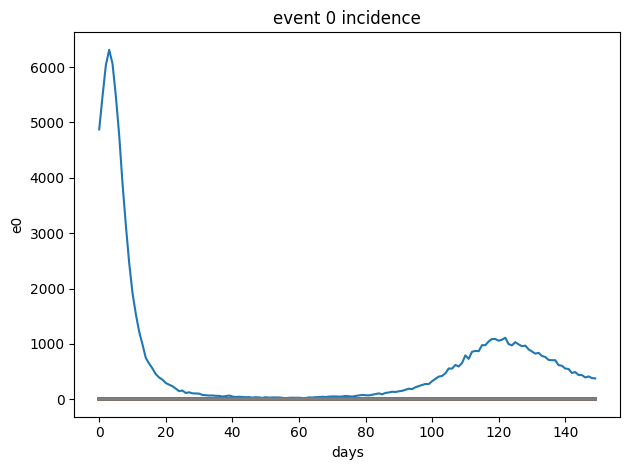

Done


In [2]:
import os

from epymorph.run import run

dir = os.path.expanduser('~/Desktop/CCL/Epymorph/scratch')

exit_code = run(
    ipm_name = 'simple_sirs',
    mm_name = 'no',
    geo_name = 'us_sw_counties_2015',
    start_date_str = '2010-01-01',
    duration_str = '150d',
    params_path = f"{dir}/params.toml",
    out_path = None,
    chart = 'e0',
    profiling = False
)

### Caching
In order to prevent long wait times for data retrieval every time the simulation runs, data fetched by ADRIOs are cached in CSV files located in a .cache folder in the adrio directory. Once data has been fetched and cached once, future retrieval of that data is instant. A CLI command also exists to fetch and cache data from ADRIOs without running the simulation, allowing users to pre-load or refresh their cache at any time. This is demonstrated below.

In [1]:
from epymorph.__main__ import do_cache

# "cache" subcommand demo
exit_code = do_cache(
    'us_sw_counties_2015',  # name of Geo
    True                    # -f arg: determines whether to overwrite existing data
)

Fetching GEO data from ADRIOs...
Fetching label: name_and_state
Fetching geoid
Fetching centroid
Fetching median_income
Fetching population
Fetching population_by_age
Fetching pop_density_km2
Fetching dissimilarity_index
...done
Data successfully cached
